In [1]:
# Python 2.x / 3.x compatibility
from __future__ import division, print_function

%matplotlib inline

#Import modules
import pandas as pd
import numpy as np
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

#import csv
import glob as gb

#import pathlib

import datetime
import sqlite3

import shutil
import multiprocessing
import subprocess

#import tqdm
from tqdm.notebook import trange, tqdm
import pathlib

from ipywidgets import HTML
from IPython.display import display

import shlex

# from df2gspread import df2gspread as d2g

mpl.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_rows = 200

In [5]:
!openstudio model/simulationtests/baseline_sys01.rb

[openstudio.WorkflowJSON] <2> Path 'in.osw' is not a WorkflowJSON file
 couldn't be found
model_Articulation: 2.037830925 seconds
Model Save: 0.020300128 seconds
ForwardTranslator: 0.052845969 seconds


In [51]:
RE_TIME = re.compile(r'(\w+): ([\d\.]+) seconds')

def run_ruby_file(args):
    """
    Runs the simulation with NEW_EPLUS_EXE and calls parse_sql
    """
    i, ruby_file = args
    p = os.path.abspath(os.path.join('model', 'simulationtests', ruby_file))
    process = subprocess.Popen(['openstudio', p],
                               stdout=subprocess.PIPE,
                               stderr=subprocess.PIPE,
                               universal_newlines=True, 
                               shell=False)
    
    # wait for the process to terminate
    out, err = process.communicate()
    errcode = process.returncode
    if errcode == 0:
        timings = {'file': ruby_file, 'i': i}
        for line in out.splitlines():
            if (m := re_time.match(line)):
                timing, val = m.groups()
                timings[timing] = float(val)
        return timings

In [23]:
from itertools import product

# Run in a single thread

In [ ]:
all_results = []
for i in range(0, 50):
    print(i)
    all_results.append(run_ruby_file([i, 'baseline_sys01.rb']))
df_single = pd.DataFrame(all_results)
df_single = df_single.set_index(['file', 'i']).sort_index()

# Run in parallel using multiprocessing.pool

In [135]:
N = 6

## Only the baseline_sys01.rb

In [148]:
desc = f'<h3>Running baseline_sys01.rb only (50 times)</h3>'
label = HTML(desc)
display(label)
all_results = []
all_tests = [x for x in product(range(0, 50), 
                                [
                                    'baseline_sys01.rb',
                                    # 'zone_hvac.rb',  # Commenting that out in one of the two runs
                                ])]
with multiprocessing.Pool(processes=N) as pool:
    for result in tqdm(pool.imap_unordered(run_ruby_file, all_tests), total=len(all_tests)):
        all_results.append(result)
        
df = pd.DataFrame(all_results)
df = df.set_index(['file', 'i']).sort_index()

HTML(value='<h3>Running baseline_sys01.rb only (50 times)</h3>')

  0%|          | 0/50 [00:00<?, ?it/s]

## Add another file (we don't care about) to increasing the total amount of runs

In [150]:
desc = f'<h3>Running both files 100 times each</h3>'
label = HTML(desc)
display(label)
all_results = []
all_tests = [x for x in product(range(0, 50), 
                                [
                                    'baseline_sys01.rb',
                                    'zone_hvac.rb',  # Commenting that out in one of the two runs
                                ])]
with multiprocessing.Pool(processes=N) as pool:
    for result in tqdm(pool.imap_unordered(run_ruby_file, all_tests), total=len(all_tests)):
        all_results.append(result)
        
df_both = pd.DataFrame(all_results)
df_both = df_both.set_index(['file', 'i']).sort_index()

HTML(value='<h3>Running both files 100 times each</h3>')

  0%|          | 0/100 [00:00<?, ?it/s]

# Look at results

In [152]:
df_all = pd.concat([df_single.loc['baseline_sys01.rb'], df.loc['baseline_sys01.rb'], df_both.loc['baseline_sys01.rb']],
                   keys=['Single Thread', 'Single file (N=6)', 'Both files (N=6)'], axis=1)

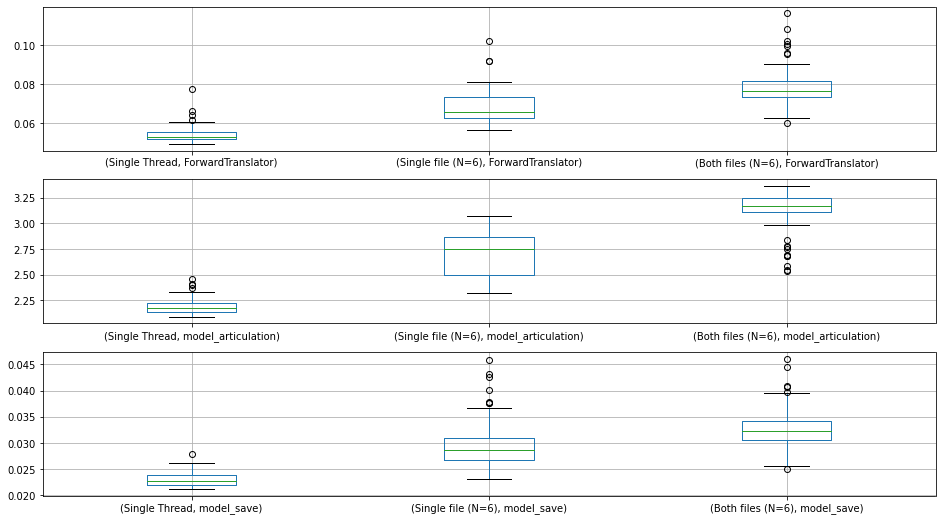

In [192]:
grouped = df_all.groupby(level=1, axis=1)

ncols = 1
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,9), sharey=False)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).boxplot(ax=ax)

plt.show()

# Run a second time and compare timings

Save a copy of the previous df_all

Now go run the above a second time, but don't run the above cell

In [191]:
diff = pd.concat([df_all_back.mean(), df_all.mean()], axis=1)
diff.pct_change(axis=1).loc[:, 1].unstack().style.format('{:.2%}')

,model_articulation,model_save,ForwardTranslator
Single Thread,-2.64%,-1.93%,-2.28%
Single file (N=6),-9.61%,-13.13%,-17.48%
Both files (N=6),-7.90%,-16.19%,-12.35%


In [188]:
means = df_all.mean().unstack(0)
means

,Single Thread,Single file (N=6),Both files (N=6)
model_articulation,2.196145,2.710449,3.102774
model_save,0.023023,0.030001,0.032897
ForwardTranslator,0.054636,0.068536,0.078916


In [189]:
means.divide(means.iloc[:, 0], axis=0)

,Single Thread,Single file (N=6),Both files (N=6)
model_articulation,1.0,1.234185,1.412827
model_save,1.0,1.303080,1.428879
ForwardTranslator,1.0,1.254420,1.444397
